In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

from utils import *

pd.set_option("display.max_columns", 100)

In [2]:
%load_ext autoreload
%autoreload 2

### Data

In [3]:
xls = pd.ExcelFile("data/IQ_Cancer_Endometrio_merged_NMSP.xlsx")
xls.sheet_names

['IQ_Cancer_Endometrio_merged_NMS', 'Variables', 'Llegenda ', 'Informació ']

In [4]:
df = pd.read_excel("data/IQ_Cancer_Endometrio_merged_NMSP.xlsx", sheet_name="IQ_Cancer_Endometrio_merged_NMS")

In [5]:
df.head()

,codigo_participante,recidiva,recidiva_exitus,diferencia_dias_reci_exit,causa_muerte,f_diag,fecha_de_recidi,f_muerte,visita_control,Ultima_fecha,FN,f_1v,edad,imc,otra_histo,tipo_histologico,Grado,valor_de_ca125,ecotv_infiltsub,ecotv_infiltobj,metasta_distan,grupo_riesgo,despues_diag,estadiaje_pre_i,est_pcte,libre_enferm,comentarios,numero_de_recid,recid_super_1,dx_recidiva,num_recidiva,loc_recidiva_r01,loc_recidiva_r02,loc_recidiva_r03,loc_recidiva_r04,loc_recidiva_r05,loc_recidiva_r06,tto_recidiva,Tt_recidiva_qx,otro_ttIQ_recid,Reseccion_macroscopica_complet,Tratamiento_RT,Tratamiento_sistemico,estado,usuario_reg1,hsp_trat_primario,presntado_cTG,centro_tratPrima,tto_NA,f_tto_NA,...,AP_ganPelv,ap_gPelv_loc,n_total_ganCent,n_gangP_afec,AP_glanPaor,Local_Gan_Paor,n_total_ganPaor_infra,n_ganPaor_InfrM_afec,n_total_ganPaor_supr,n_ganPaor_Sup_afec,ap_gPaor_total,ap_gPor_afect_tot,ap_comentarios,recep_est_porcent,rece_de_Ppor,p53_molecular,p53_ihq,mut_pole,beta_cateninap,msh2,msh6,pms2,mlh1,estudio_genetico_r01,estudio_genetico_r02,estudio_genetico_r03,estudio_genetico_r04,estudio_genetico_r05,estudio_genetico_r06,estadificacion_,tabla_de_estadi,FIGO2023,grupo_de_riesgo_definitivo,tabla_de_riesgo,Tributaria_a_Radioterapia,rdt,rt_dosis,n_doisis_rt,moti_no_RT,bqt,bt_realPac,ini_bqt_rt,final_bqt_rt,qt,Tratamiento_sistemico_realizad,inicio_qmt,fecha_final_qmt,otros_tt,tt_o_f_ini,tt_o_f_fin
0,4,0,0,626.0,NaN,2023-11-03,NaN,NaN,21/07/2025,2025-07-21,12/10/1955,03/11/2023,68.0,39.40,NaN,2,2,283.0,2.0,4.0,1.0,3.0,1,2.0,1,0,estad�o IV por diseminaci�n pulmonar (varios ...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2965,1,1,NaN,0,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,"OVARIO Y TROMPA DE FALLOPIO IZQUIERDOS, ANEXEC...",80.0,10.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,NaN,14.0,5.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,2.0,14/02/2024,04/04/2024,NaN,NaN,NaN
1,7,0,0,244.0,1.0,2019-10-24,NaN,08/04/2021,24/06/2020,2020-06-24,24/09/1926,11/04/2019,92.0,24.14,y escasos focos de endocarcinoma endometroide,1,1,NaN,4.0,3.0,0.0,1.0,0,NaN,2,0,Es notifica que la pacient rebutja la realitza...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2965,0,1,No iQx como tto primario. comorbilidades varias.,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,0,1769.0,NaN,2020-07-16,NaN,NaN,20/05/2025,2025-05-20,26/11/1947,15/07/2020,72.0,38.80,NaN,2,1,NaN,4.0,3.0,0.0,1.0,1,0.0,1,1,en paralel dx 2020 linfoma linfocitic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2965,1,1,NaN,0,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,"ADENOPAT�A MESENTERIO, RESECCI�N: - UN GANGLIO...",NaN,NaN,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1,1,1003.0,NaN,2021-02-22,22/11/2023,NaN,27/10/2025,2023-11-22,15/10/1942,11/02/2021,78.0,36.30,NaN,2,1,NaN,3.0,3.0,0.0,2.0,1,1.0,1,1,NaN,1.0,recidiva adenopatica. ttm SBRT,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,1.0,0.0,2,2965,1,1,NaN,0,NaN,...,3.0,2.0,15.0,3.0,3.0,3.0,7.0,3.0,8.0,1.0,14.0,4.0,"VAGINA, AMPLIACI�N MARGEN LATERAL IZQUIERDO: -...",90.0,90.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,NaN,11.0,5.0,NaN,1.0,2.0,2.0,25.0,NaN,1.0,1.0,08/10/2021,12/11/2021,1.0,2.0,06/05/2021,20/08/2021,NaN,NaN,NaN
4,10,0,0,1917.0,NaN,2019-11-15,NaN,NaN,13/02/2025,2025-02-13,06/07/1951,12/11/2019,68.0,31.10,NaN,2,1,NaN,3.0,NaN,0.0,1.0,1,0.0,1,1,Alta hospital�ria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2965,1,1,NaN,0,NaN,...,NaN,2.0,16.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,90.0,90.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Processing

### Date Conversion

In [6]:
date_cols = [
    "fecha_qx",
    "fecha_de_recidi",
    "Ultima_fecha",
    "f_muerte"
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)

In [7]:
df[date_cols].isna().mean()

fecha_qx           0.079755
fecha_de_recidi    0.822086
Ultima_fecha       0.000000
f_muerte           0.834356
dtype: float64

In [8]:
df["recidiva"].value_counts(dropna=False)

recidiva
0    125
1     29
2      9
Name: count, dtype: int64

### Event creation -> if patient has recurrence

In [9]:
df["event"] = df["recidiva"].isin([1, 2]).astype(int)

In [10]:
df["time_days"] = np.where(
    df["event"] == 1,
    (df["fecha_de_recidi"] - df["fecha_qx"]).dt.days,
    (df["Ultima_fecha"] - df["fecha_qx"]).dt.days
)

In [11]:
df_surv = df[
    df["fecha_qx"].notna() &        # cirugía conocida
    df["time_days"].notna() &       # tiempo calculable
    (df["time_days"] > 0)           # tiempo válido
].copy()

print("Total patients:", len(df))
print("Patients with valid DFS:", len(df_surv))
print("Events:", df_surv["event"].sum())

Total patients: 163
Patients with valid DFS: 142
Events: 28


# Models

## Cox Survival Model + Core Features

In [12]:
print("NSMP patients:", len(df_surv))
print("NSMP events:", int(df_surv["event"].sum()))
print(df_surv[["time_days", "event"]].describe())

NSMP patients: 142
NSMP events: 28
         time_days       event
count   142.000000  142.000000
mean   1061.746479    0.197183
std     663.922114    0.399280
min      25.000000    0.000000
25%     450.750000    0.000000
50%     988.000000    0.000000
75%    1687.250000    0.000000
max    2481.000000    1.000000


In [13]:
core_features = [
    "edad",
    "imc",
    "grado_histologi",     # or "Grado"
    "tamano_tumoral",
    "infiltracion_mi",
    "infilt_estr_cervix",
    "afectacion_linf",     # often LVSI/lymphovascular invasion
    "n_gangP_afec",        # # pelvic nodes affected (if present)
    "n_GC_Afect",          # # sentinel nodes affected (if present)
    "recep_est_porcent",   # ER %
    "rece_de_Ppor"         # PR %
]

In [14]:
model_df = df_surv[core_features + ["time_days", "event"]].copy()

### Missing imputation

In [15]:
num_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
model_df[num_cols] = model_df[num_cols].fillna(model_df[num_cols].median())

cat_cols = model_df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["time_days", "event"]]

model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

### Train / Test split

In [16]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
print(train_df.shape, test_df.shape)

(113, 13) (29, 13)


### Model

In [17]:
cph = CoxPHFitter(penalizer=0.1)  # adjust if unstable: try 0.01, 0.5
cph.fit(train_df, duration_col="time_days", event_col="event")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 113 total observations, 92 right-censored observations>
             duration col = 'time_days'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 113
number of events observed = 21
   partial log-likelihood = -70.17
         time fit was run = 2025-12-13 19:06:20 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
edad               -0.02      0.98      0.01           -0.05            0.01                0.95                1.01
imc                -0.04      0.96      0.03           -0.10            0.02                0.91                1.02
grado_histologi     1.34      3.83      0.47            0.42            2.26                1.53                9.60
tamano_tumoral      0.05      1.05      0.03           -0.01            0.11                0.99                1.11
infiltracion_mi     0.30      1.35      0.24           -0.18            0.77                0.84                2.17
infilt_estr_cervix  0.17      1.18      0.52           -0.85            1.18                0.43                3.26
afectacion_linf     0.64      1.91      0.46           -0.25            1.54                0.78                4.68
n_gangP_afec        0.22      1.25      0.19           -0.15            0.59                0.86                1.80
n_GC_Afect          0.30      1.35      0.68           -1.04            1.64                0.35                5.15
recep_est_porcent  -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
rece_de_Ppor        0.00      1.00      0.01           -0.01            0.02                0.99                1.02

                    cmp to     z      p  -log2(p)
covariate                                        
edad                  0.00 -1.49   0.14      2.88
imc                   0.00 -1.44   0.15      2.74
grado_histologi       0.00  2.87 <0.005      7.91
tamano_tumoral        0.00  1.59   0.11      3.15
infiltracion_mi       0.00  1.23   0.22      2.19
infilt_estr_cervix    0.00  0.32   0.75      0.42
afectacion_linf       0.00  1.41   0.16      2.64
n_gangP_afec          0.00  1.18   0.24      2.08
n_GC_Afect            0.00  0.44   0.66      0.60
recep_est_porcent     0.00 -1.29   0.20      2.34
rece_de_Ppor          0.00  0.40   0.69      0.53
---
Concordance = 0.92
Partial AIC = 162.34
log-likelihood ratio test = 40.11 on 11 df
-log2(p) of ll-ratio test = 14.83

**C-index**: Can the model correctly order patients by who relapses earlier?

In [18]:
risk_test = cph.predict_partial_hazard(test_df)

c_index = concordance_index(
    test_df["time_days"],
    -risk_test,                  # negative because higher risk = shorter survival
    test_df["event"]
)
print("Test C-index:", c_index)

Test C-index: 0.8014184397163121


Checks assumption:
The effect of a variable on risk is constant over time.

In [19]:
cph.check_assumptions(train_df, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

Calculates partial hazard score and divides into 3 groups

In [20]:
df_surv_eval = df_surv.copy()

# Build same columns as model_df (important)
X_all = df_surv[core_features + ["time_days", "event"]].copy()
for c in core_features:
    X_all[c + "_missing"] = X_all[c].isna().astype(int)
X_all[X_all.select_dtypes(include=[np.number]).columns] = X_all.select_dtypes(include=[np.number]).fillna(
    X_all.select_dtypes(include=[np.number]).median()
)

cat_cols_all = X_all.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols_all = [c for c in cat_cols_all if c not in ["time_days", "event"]]
X_all = pd.get_dummies(X_all, columns=cat_cols_all, drop_first=True)

# Align columns to training set
X_all = X_all.reindex(columns=train_df.columns, fill_value=0)

df_surv_eval["risk_score"] = cph.predict_partial_hazard(X_all)

df_surv_eval["risk_group"] = pd.qcut(
    df_surv_eval["risk_score"],
    q=3,
    labels=["Low", "Medium", "High"]
)
df_surv_eval["risk_group"].value_counts()

risk_group
High      48
Low       47
Medium    47
Name: count, dtype: int64

Next plots checks if it matches reality?

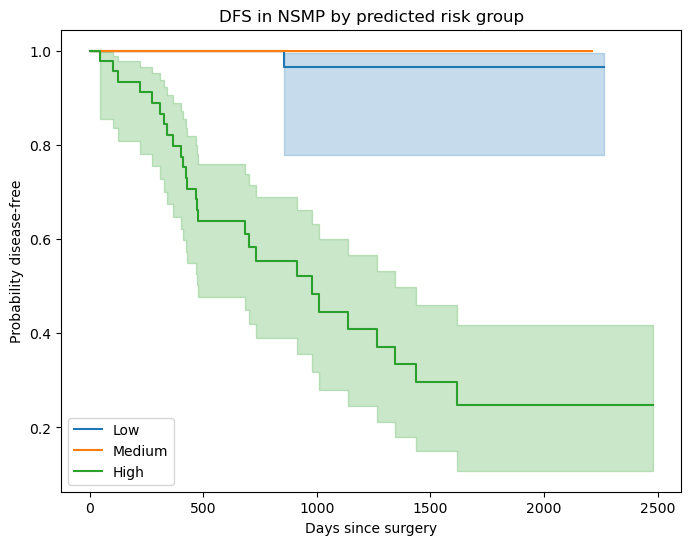

In [21]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for g in ["Low", "Medium", "High"]:
    m = df_surv_eval["risk_group"] == g
    kmf.fit(df_surv_eval.loc[m, "time_days"], df_surv_eval.loc[m, "event"], label=g)
    kmf.plot_survival_function()

plt.title("DFS in NSMP by predicted risk group")
plt.xlabel("Days since surgery")
plt.ylabel("Probability disease-free")
plt.show()


In [22]:
seeds = [0, 1, 2, 3, 4]
cindices = [c_index_check(df_surv, core_features, s) for s in seeds]

pd.Series(cindices, name="C-index")

0    0.800000
1    0.811765
2    0.904255
3    0.869863
4    0.941748
Name: C-index, dtype: float64

In [23]:
penalty_value_check(df_surv, core_features)

[{'penalizer': 0.01, 'C_index': np.float64(0.7588652482269503)},
 {'penalizer': 0.1, 'C_index': np.float64(0.8014184397163121)},
 {'penalizer': 0.5, 'C_index': np.float64(0.7588652482269503)}]

## Cox Survival Model + All Features

In [24]:
all_features = [
    # Patient factors
    "edad",
    "imc",
    "asa",

    # Tumor histology & pathology
    "tipo_histologico",
    "grado_histologi",
    "tamano_tumoral",
    "infiltracion_mi",
    "afectacion_linf",
    "metasta_distan",

    # Nodal status
    "AP_centinela_pelvico",
    "n_GC_Afect",
    "AP_ganPelv",
    "n_gangP_afec",
    "AP_glanPaor",
    "n_ganPaor_InfrM_afec",
    "n_ganPaor_Sup_afec",

    # Biomarkers
    "recep_est_porcent",
    "rece_de_Ppor",
    "estudio_genetico_r01",
    "estudio_genetico_r02",
    "estudio_genetico_r03",
    "estudio_genetico_r04",
    "estudio_genetico_r05",
    "estudio_genetico_r06",

    # Staging
    "FIGO2023",
    "estadiaje_pre_i"
]


In [25]:
model_df = df_surv[all_features + ["time_days", "event"]].copy()
num_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
model_df[num_cols] = model_df[num_cols].fillna(model_df[num_cols].median())

cat_cols = model_df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["time_days", "event"]]

model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

In [26]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
print(train_df.shape, test_df.shape)

(113, 28) (29, 28)


This yields error:

In [27]:
#cph = CoxPHFitter(penalizer=0.1)  # adjust if unstable: try 0.01, 0.5
#cph.fit(train_df, duration_col="time_days", event_col="event")

#cph.print_summary()

This could be because of survivors constraint of 10 events per independent predictor (we have 35-40 events -> Safe predictors: ≈ 4–6 not 27 in our case).

We can try to **summarize** variables

In [28]:
df_surv["nodal_positive"] = (
    (df_surv["n_GC_Afect"] > 0) |
    (df_surv["n_gangP_afec"] > 0) |
    (df_surv["n_ganPaor_InfrM_afec"] > 0) |
    (df_surv["n_ganPaor_Sup_afec"] > 0)
).astype(int)

gen_cols = [f"estudio_genetico_r0{i}" for i in range(1,7)]
df_surv["genetic_test_done"] = df_surv[gen_cols].notna().any(axis=1).astype(int)

df_surv["genetic_abnormal"] = (df_surv[gen_cols] == 1).any(axis=1).astype(int)

In [29]:
summ_features = [
    # Patient
    "edad",
    "imc",
    "asa",

    # Tumor aggressiveness
    "grado_histologi",
    "tamano_tumoral",
    "infiltracion_mi",
    "afectacion_linf",

    # Spread
    "nodal_positive",
    "metasta_distan",

    # Biomarkers
    "recep_est_porcent",
    "rece_de_Ppor",
    "genetic_abnormal",
    "genetic_test_done",

    # Stage
    "FIGO2023"
]

In [30]:
model_df = df_surv[summ_features + ["time_days", "event"]].copy()
num_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
model_df[num_cols] = model_df[num_cols].fillna(model_df[num_cols].median())

cat_cols = model_df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["time_days", "event"]]

model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

In [31]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
print(train_df.shape, test_df.shape)

(113, 16) (29, 16)


In [32]:
cph = CoxPHFitter(penalizer=0.1)  # adjust if unstable: try 0.01, 0.5
cph.fit(train_df, duration_col="time_days", event_col="event")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 113 total observations, 92 right-censored observations>
             duration col = 'time_days'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 113
number of events observed = 21
   partial log-likelihood = -64.65
         time fit was run = 2025-12-13 19:06:21 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
edad              -0.02      0.98      0.02           -0.05            0.01                0.96                1.01
imc               -0.03      0.97      0.03           -0.09            0.02                0.91                1.02
asa               -0.40      0.67      0.38           -1.14            0.34                0.32                1.40
grado_histologi    1.15      3.16      0.49            0.20            2.10                1.22                8.19
tamano_tumoral     0.06      1.06      0.03           -0.01            0.12                0.99                1.13
infiltracion_mi    0.18      1.20      0.25           -0.31            0.67                0.74                1.95
afectacion_linf    0.54      1.71      0.47           -0.39            1.47                0.68                4.35
nodal_positive     0.99      2.69      0.49            0.04            1.94                1.04                6.97
metasta_distan     1.38      3.96      0.75           -0.09            2.85                0.91               17.23
recep_est_porcent -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
rece_de_Ppor       0.00      1.00      0.01           -0.01            0.02                0.99                1.02
genetic_abnormal  -0.51      0.60      1.11           -2.68            1.66                0.07                5.28
genetic_test_done -0.51      0.60      1.11           -2.68            1.66                0.07                5.28
FIGO2023           0.07      1.07      0.05           -0.03            0.17                0.97                1.18

                   cmp to     z    p  -log2(p)
covariate                                     
edad                 0.00 -1.05 0.29      1.77
imc                  0.00 -1.16 0.25      2.02
asa                  0.00 -1.06 0.29      1.80
grado_histologi      0.00  2.37 0.02      5.81
tamano_tumoral       0.00  1.79 0.07      3.78
infiltracion_mi      0.00  0.73 0.47      1.10
afectacion_linf      0.00  1.14 0.26      1.97
nodal_positive       0.00  2.03 0.04      4.57
metasta_distan       0.00  1.84 0.07      3.92
recep_est_porcent    0.00 -1.92 0.05      4.19
rece_de_Ppor         0.00  0.26 0.80      0.33
genetic_abnormal     0.00 -0.46 0.65      0.63
genetic_test_done    0.00 -0.46 0.65      0.63
FIGO2023             0.00  1.39 0.16      2.61
---
Concordance = 0.92
Partial AIC = 157.30
log-likelihood ratio test = 51.15 on 14 df
-log2(p) of ll-ratio test = 17.96

In [33]:
risk_test = cph.predict_partial_hazard(test_df)

c_index = concordance_index(
    test_df["time_days"],
    -risk_test,                  # negative because higher risk = shorter survival
    test_df["event"]
)
print("Test C-index:", c_index)

Test C-index: 0.7730496453900709


In [34]:
cph.check_assumptions(train_df, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

In [35]:
df_surv_eval = df_surv.copy()

# Build same columns as model_df (important)
X_all = df_surv[core_features + ["time_days", "event"]].copy()
for c in core_features:
    X_all[c + "_missing"] = X_all[c].isna().astype(int)
X_all[X_all.select_dtypes(include=[np.number]).columns] = X_all.select_dtypes(include=[np.number]).fillna(
    X_all.select_dtypes(include=[np.number]).median()
)

cat_cols_all = X_all.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols_all = [c for c in cat_cols_all if c not in ["time_days", "event"]]
X_all = pd.get_dummies(X_all, columns=cat_cols_all, drop_first=True)

# Align columns to training set
X_all = X_all.reindex(columns=train_df.columns, fill_value=0)

df_surv_eval["risk_score"] = cph.predict_partial_hazard(X_all)

df_surv_eval["risk_group"] = pd.qcut(
    df_surv_eval["risk_score"],
    q=3,
    labels=["Low", "Medium", "High"]
)
df_surv_eval["risk_group"].value_counts()

risk_group
Low       48
High      48
Medium    46
Name: count, dtype: int64

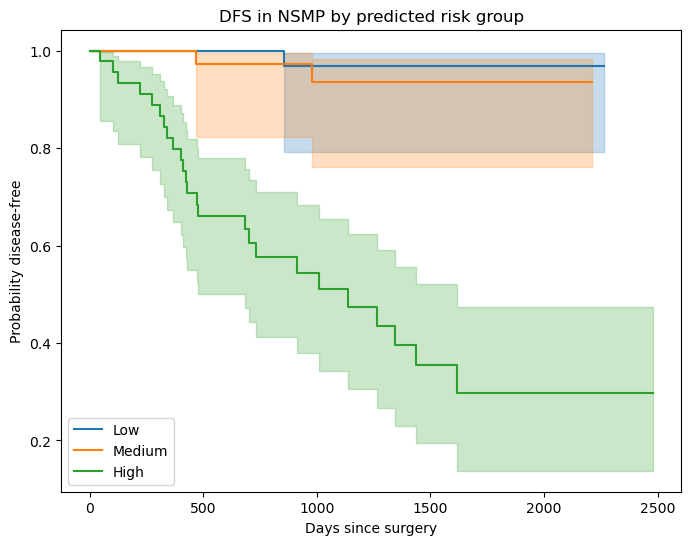

In [36]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for g in ["Low", "Medium", "High"]:
    m = df_surv_eval["risk_group"] == g
    kmf.fit(df_surv_eval.loc[m, "time_days"], df_surv_eval.loc[m, "event"], label=g)
    kmf.plot_survival_function()

plt.title("DFS in NSMP by predicted risk group")
plt.xlabel("Days since surgery")
plt.ylabel("Probability disease-free")
plt.show()

In [37]:
seeds = [0, 1, 2, 3, 4]
cindices = [c_index_check(df_surv, summ_features, s) for s in seeds]

pd.Series(cindices, name="C-index")

0    0.814286
1    0.823529
2    0.936170
3    0.869863
4    0.970874
Name: C-index, dtype: float64

In [38]:
penalty_value_check(df_surv, summ_features)

[{'penalizer': 0.01, 'C_index': np.float64(0.723404255319149)},
 {'penalizer': 0.1, 'C_index': np.float64(0.7730496453900709)},
 {'penalizer': 0.5, 'C_index': np.float64(0.7659574468085106)}]

In [42]:
save_model(df_surv, summ_features, "model")

<lifelines.CoxPHFitter: fitted with 113 total observations, 92 right-censored observations>